In [24]:
# import packages - \src\utils\start_wrapper.py
from src.utils.start_wrapper import *
wrapper_notebook_settings()

# Load dictionary of project paths
import src.utils.paths
paths = src.utils.paths.paths_dictionary()
print("Contents of paths dictionary:")
for key in paths:
    print(key, ": ", paths[key])

import src.data.make_dataset
import src.utils.df_inspect


# Why I dont have packages in utils.start_wrapper? Because pylint wouldn't recognize them
#  basic packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# Load environment variables
import dotenv
import os
dotenv.load_dotenv(os.path.join(os.path.dirname(os.getcwd()), '.env'))

# project specific packages
import urllib.request
import seaborn as sns
import sklearn as sk
from sklearn import metrics

# FB module for forecasting
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Contents of paths dictionary:
data :  /app/data/
docs :  /app/docs/
models :  /app/models/
notebooks :  /app/notebooks/
references :  /app/references/
reports :  /app/reports/
src :  /app/src/
app :  /app/
data_external :  /app/data/external/
data_interim :  /app/data/interim/
data_processed :  /app/data/processed/
data_raw :  /app/data/raw/
reports_figures :  /app/reports/figures/
src_data :  /app/src/data/
src_features :  /app/src/features/
src_models :  /app/src/models/
src_utils :  /app/src/utils/
src_visualization :  /app/src/visualization/


In [25]:
# Parameters section

seed = 123  # random seed for reproducibility of results
forecast_days = 7  # number of days to forecast
start_date = '1984-09-07'
end_date = '2024-02-27'
stock = 'aapl.us'

np.random.seed(seed)  # setting random number generator in numpy for reproducibility of results

In [26]:
# Kids, don't do this at home
os.environ['secret_apiKey']

'S0_S3cR3T'

In [27]:
# Load data from Stooq
data_in = src.data.make_dataset.stooqData(stock)

# Save data to csv
data_in.to_csv(paths['data_raw']+stock+'.csv', index=False) 

In [28]:
src.utils.df_inspect.DataFrameInspector(data_in)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9948 entries, 0 to 9947
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    9948 non-null   datetime64[ns]
 1   open    9948 non-null   float64       
 2   high    9948 non-null   float64       
 3   low     9948 non-null   float64       
 4   close   9948 non-null   float64       
 5   volume  9948 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 466.4 KB
None 

First 5 Rows of the DataFrame:
        date      open      high       low     close        volume
0 1984-09-07  0.100763  0.101999  0.099546  0.100763  9.767604e+07
1 1984-09-10  0.100763  0.101071  0.098340  0.100165  7.581254e+07
2 1984-09-11  0.101071  0.103814  0.101071  0.101999  1.787705e+08
3 1984-09-12  0.101999  0.102597  0.098928  0.098928  1.561713e+08
4 1984-09-13  0.104432  0.104730  0.104432  0.104432  2.432310e+08 

Last 5 Rows of the Data

In [29]:
# Checking wheter close price is adjusted for stock splits or not
# Apple had 7:1 stock split in 2014-06-09
data_in[(data_in["date"].dt.year == 2014) & (data_in["date"].dt.month == 6)]

# Close price is adjusted

,date,open,high,low,close,volume
7495,2014-06-02,20.1924,20.2184,19.8275,20.0229,4.139481e+08
7496,2014-06-03,20.0169,20.3430,20.0120,20.3050,3.283111e+08
7497,2014-06-04,20.3021,20.6381,20.2592,20.5383,3.760571e+08
7498,2014-06-05,20.5833,20.6849,20.4675,20.6201,3.404549e+08
7499,2014-06-06,20.7009,20.7427,20.5273,20.5623,3.926505e+08
7500,2014-06-09,20.6699,20.9292,20.4566,20.8892,3.377682e+08
7501,2014-06-10,21.1216,21.1933,20.8614,21.0119,2.813494e+08
7502,2014-06-11,20.9860,21.1276,20.8394,20.9252,2.046828e+08
7503,2014-06-12,20.9630,20.9840,20.4895,20.5783,2.453256e+08
7504,2014-06-13,20.5583,20.6111,20.2612,20.3499,2.444800e+08


In [30]:
train = data_in[['date', 'close']][:-forecast_days].copy()  # All data except the last 7 observations
train.columns = ['ds', 'y']  # Renaming columns to fit Prophet's requirements
display('train dataset size:', train.shape)
test = data_in[['date', 'close']][-forecast_days:].copy()   # Last 7 observations
test.columns = ['ds', 'y']  # Renaming columns to fit Prophet's requirements
display('train dataset size:', test.shape)

'train dataset size:'

(9941, 2)

'train dataset size:'

(7, 2)

In [31]:
train.tail()

,ds,y
9936,2024-02-12,187.15
9937,2024-02-13,185.04
9938,2024-02-14,184.15
9939,2024-02-15,183.86
9940,2024-02-16,182.31


In [32]:
test

,ds,y
9941,2024-02-20,181.560
9942,2024-02-21,182.320
9943,2024-02-22,184.370
9944,2024-02-23,182.520
9945,2024-02-26,181.160
9946,2024-02-27,182.630
9947,2024-02-28,180.225


In [33]:
# Train forecasting model
m = Prophet()
m.fit(train)

18:22:15 - cmdstanpy - INFO - Chain [1] start processing
18:22:20 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
# Python
future = m.make_future_dataframe(periods=2*forecast_days) # 2*forecast_days to include weekends
future = future[future['ds'].dt.dayofweek < 5] # exclude weekends
future.tail(10)

,ds
9943,2024-02-19
9944,2024-02-20
9945,2024-02-21
9946,2024-02-22
9947,2024-02-23
9950,2024-02-26
9951,2024-02-27
9952,2024-02-28
9953,2024-02-29
9954,2024-03-01


In [35]:
# Predict the future
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9946,2024-02-26,184.841477,174.110716,194.231373
9947,2024-02-27,184.872357,174.702097,194.307193
9948,2024-02-28,184.911554,174.859093,195.517138
9949,2024-02-29,184.886934,174.530904,195.055907
9950,2024-03-01,184.822401,174.491202,194.597707


In [36]:
test

,ds,y
9941,2024-02-20,181.560
9942,2024-02-21,182.320
9943,2024-02-22,184.370
9944,2024-02-23,182.520
9945,2024-02-26,181.160
9946,2024-02-27,182.630
9947,2024-02-28,180.225


In [37]:
test_forecast = test.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')
test_forecast.tail()

,ds,y,yhat,yhat_lower,yhat_upper
2,2024-02-22,184.370,184.848080,174.827027,194.823581
3,2024-02-23,182.520,184.768819,174.764574,194.635153
4,2024-02-26,181.160,184.841477,174.110716,194.231373
5,2024-02-27,182.630,184.872357,174.702097,194.307193
6,2024-02-28,180.225,184.911554,174.859093,195.517138


In [38]:
full_sample = pd.concat([train, test_forecast], ignore_index=True, sort=False)
full_sample = full_sample[full_sample['y'].notnull()] # remove rows without ground truth

In [39]:
full_sample.tail(2*forecast_days)

,ds,y,yhat,yhat_lower,yhat_upper
9934,2024-02-08,188.320,NaN,NaN,NaN
9935,2024-02-09,188.850,NaN,NaN,NaN
9936,2024-02-12,187.150,NaN,NaN,NaN
9937,2024-02-13,185.040,NaN,NaN,NaN
9938,2024-02-14,184.150,NaN,NaN,NaN
9939,2024-02-15,183.860,NaN,NaN,NaN
9940,2024-02-16,182.310,NaN,NaN,NaN
9941,2024-02-20,181.560,184.849687,175.132400,195.277128
9942,2024-02-21,182.320,184.883074,174.674118,195.214380
9943,2024-02-22,184.370,184.848080,174.827027,194.823581


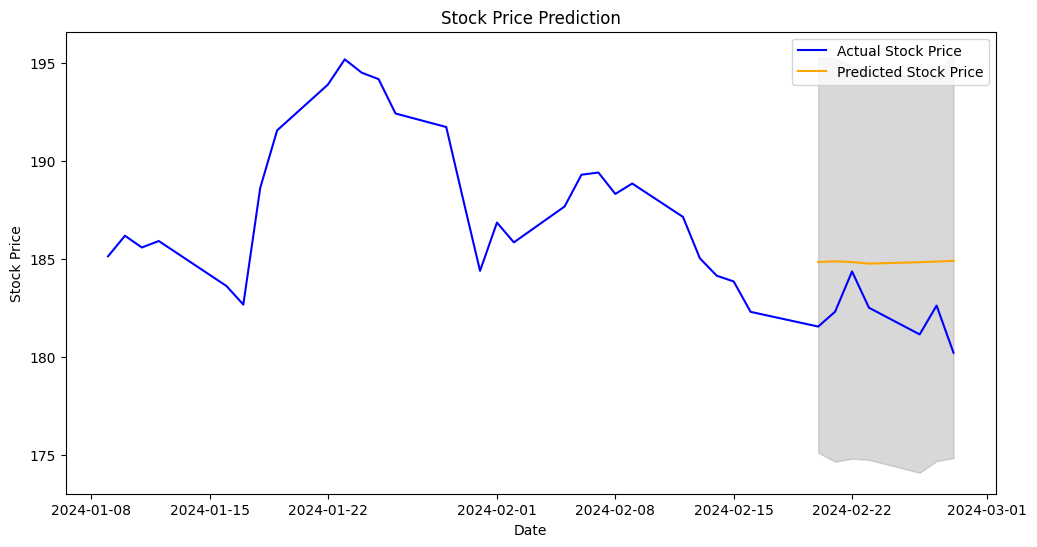

In [40]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full_sample['ds'][-5*forecast_days:], full_sample['y'][-5*forecast_days:], label='Actual Stock Price', color='blue')
plt.plot(full_sample['ds'][-5*forecast_days:], full_sample['yhat'][-5*forecast_days:], label='Predicted Stock Price', color='orange')

# Shading the area for prediction intervals
# Assuming the last 7 observations have the forecast data
plt.fill_between(full_sample['ds'][-7:], full_sample['yhat_lower'][-forecast_days:], full_sample['yhat_upper'][-forecast_days:], color='gray', alpha=0.3)

# Adding labels, title and legend
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')
plt.legend()

# Show the plot
plt.show()

In [41]:
# Export full dataset
full_sample.to_csv(paths['data_processed']+'forecast_full_sample.csv', index=False) 

In [42]:
# image of a poor prophet
# bad prophet, bad

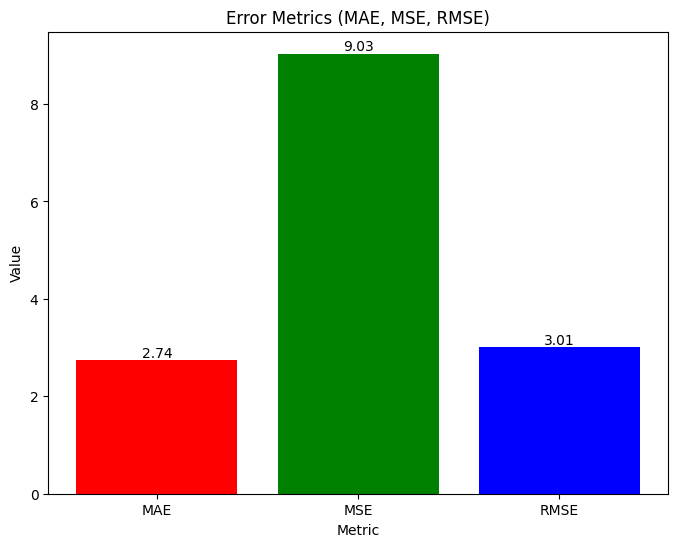

In [43]:
# Assuming 'full_sample' is your DataFrame with the actual and predicted values
# And you're focusing on the last 40 observations
actual = full_sample[full_sample['yhat'].notnull()]['y']
predicted = full_sample[full_sample['yhat'].notnull()]['yhat']

# Calculate MAE, MSE, and RMSE
mae = sk.metrics.mean_absolute_error(actual, predicted)
mse = sk.metrics.mean_squared_error(actual, predicted)
rmse = np.sqrt(mse) # RMSE is the square root of MSE

# Metrics and their names
metrics = [mae, mse, rmse]
metric_names = ['MAE', 'MSE', 'RMSE']

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(metric_names, metrics, color=['red', 'green', 'blue'])

# Adding the value on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Error Metrics (MAE, MSE, RMSE)')

# Saving the plot
plt.savefig(paths['reports_figures']+'error_metrics.png')
# Show the plot
plt.show()



In [44]:
# Python serializing
# For prophet there can be problems with pickling -> hence we use serialization


with open(paths['models']+'m001_tg_appl.json', 'w') as fout:
    fout.write(model_to_json(m))  # Save model

In [45]:
with open(paths['models']+'m001_tg_appl.json', 'r') as fin:
    m_test = model_from_json(fin.read())  # Load model

In [46]:
forecast_check = m_test.predict(future)

# Assuming df1 and df2 are your DataFrames
import pandas.testing
try:
    pandas.testing.assert_frame_equal(forecast, forecast_check)
    are_completely_same = True
except AssertionError:
    are_completely_same = False
print(f"Are the two DataFrames the same? {are_completely_same}")

# confidence intervals yhat_lower and yhat_uppe would be different if we wouldnt set np.random.seed(seed) to constant value

Are the two DataFrames the same? False


https://github.com/facebook/prophet/issues/1124

Stochasticity comes in the prediction stage, and derives entirely from the trend uncertainty estimation. Increasing uncertainty_samples reduces variance in yhat_upper but it is still stochastic.